
# Wavy Field - disentangling cos2g and depolarization
This notebook generates a 3D cube (8×8×8) containing: 
- An intrinsic (user-defined) POS **sinusoidal** pattern, which varies in amplitude in the Z direction (LOS).
- Random POS **turbulence**, which perturbs the resulting POS field, creating depoarization on integration
- Compute Stokes **Q** and **U**
- Computes **Zeeman** from intrinsic (user-defined) Bz strength.
- Estimates **DCF**, POS B field strength, by finding angular dispersion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def wavy_field_depol_test(turb_sigma, Bz_true, amplitude_range, g_size, plotting):

    """ 
    wavy_field_depol_test():
    Simulates a wavy magnetic field including:
        Random POS turbulence    
        Zeeman effect            
        Geometric depolarization 
            
    Inputs:
        turb_sigma: (float) standard deviation of angular turbulence (radians)
        Bz_true: (float) LOS magnetic field strength
        amplitude_range: (tuple) min and max amplitude of the wavy field along LOS
        g_size: (int) grid size (number of pixels along each axis)
        plotting: (bool) whether to generate plots for visual checks
    
    Outputs:
        P_obs: (2D array) observed fractional polarization after LOS integration
        phi_obs: (2D array) observed polarization angle after LOS integration
        cos2g_LOS: (2D array) average cos²γ along LOS
    
    """

    # =============================
    # user-defined parameters
    # =============================
    I0 = 1.0               # Stokes I; intensity per voxel (constant here)
    frequency = 1.0        # frequency of the wavy field in POS
    amplitude = np.linspace(amplitude_range[0],amplitude_range[1],g_size)    # amplitude varies along LOS for geometric depolarization
    L = 0.5

    # magnetic field strength of Bx, By components:
    Bx0 = 1.0              
    By0 = 1.0
    
    # Turbulence along LOS: controls angular perturbations (radians)
    corr_r = 0.9        # AR(1) correlation coefficient along the z-axis (0 = white; close to 1 = highly correlated)

    # =============================
    # generate wavy field pattern
    # =============================
    x = np.linspace(-np.pi, np.pi, g_size)
    y = np.linspace(-np.pi, np.pi, g_size)
    z = np.linspace(-np.pi, np.pi, g_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

    Bx = np.zeros(X.shape)
    By = np.zeros(Y.shape)
    Bz = np.zeros(Z.shape)

    # Sinusoidal Field in POS, Vary in amplitude along LOS axis to test geometric depolarization
    for i in range(len(Z)):
        theta0 = amplitude[i] * np.cos(frequency * X[:,:,i])
        Bx[:,:,i] = Bx0*np.cos(theta0)
        By[:,:,i] = By0*np.sin(theta0)
        Bz[:,:,i] = np.ones_like(theta0) * Bz_true

    # =============================
    # Add POS turbulence using AR(1) model
    # =============================
    delta_theta = np.zeros((g_size, g_size, g_size))

    for ix in range(g_size):
        for iy in range(g_size):
            val = np.random.normal(scale=turb_sigma) # generate an initial random turbulent angle, based on turb_sigma - the maximum angular deviation
            for iz in range(g_size):
                delta_theta[ix, iy, iz] = val # fill with current value
                # generate next value using autoregressive model
                val = corr_r * val + np.random.normal(scale=turb_sigma * np.sqrt(1 - corr_r**2)) # AR(1) process
                
    # Apply turbulence: rotate POS components
    Bx = Bx * np.cos(delta_theta) - By * np.sin(delta_theta)
    By = Bx * np.sin(delta_theta) + By * np.cos(delta_theta)
    Bz = Bz  # LOS field unaffected by angular turbulence

    # =============================
    # plotting check
    # =============================
    if plotting == True:
        fig, ax = plt.subplots(1, g_size, figsize=(20, 2))
        for i in range(g_size):
            ax[i].quiver(
                X[:,:,i], Y[:,:,i],
                Bx[:,:,i], By[:,:,i],
                pivot='middle', scale=2, scale_units='xy',headaxislength=0,
                headlength=0,headwidth=1
            )
            ax[i].set_title(f"Slice {i+1}")

    # =============================
    # calculate stokes
    # =============================
    Bperp2 = Bx**2 + By**2
    Btot2  = Bperp2 + Bz**2

    cos2g = Bperp2 / (Btot2 + 1e-12)
    q = (By**2 - Bx**2) / Btot2
    u = (2*Bx*By) / Btot2

    # Include intensity scaling
    Q3 = I0 * q 
    U3 = I0 * u

    # integrate along LOS
    Q_obs = Q3.sum(axis=2) 
    U_obs = U3.sum(axis=2) 
    I_obs = I0 * g_size  # total intensity 

    # calculate observables
    P_obs   = np.sqrt(Q_obs**2 + U_obs**2) / I_obs  # fractional polarization after LOS integration
    phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)        # observed polarization angle (radians)
    cos2g_LOS   = cos2g.mean(axis=2)                # average cos2g along LOS
    
    # =============================
    # plotting check
    # =============================
    if plotting == True:
        fig, ax = plt.subplots(1, g_size, figsize=(26, 4))
        for i in range(g_size):
            im = ax[i].imshow(cos2g[:,:,i], origin="lower",
                              extent=[-L, L, -L, L], cmap="inferno")
            plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f"Slice {i+1}")
            fig.tight_layout()

    return P_obs, phi_obs, cos2g_LOS

### Run wavy_field_depol_test

In [2]:
# run model for user-defined parameters
gsize = 64
Bztrue = 1
P, PHI, C = wavy_field_depol_test(turb_sigma = 0.25, Bz_true = Bztrue, amplitude_range = [0,1], 
                                      g_size = gsize, plotting = False)

### Add noise to Zeeman Map, create Zeeman observable

In [3]:
# === SIMULATED ZEEMAN MEASUREMENTS (LOS B) ===
zeeman_noise_sigma = 0.3  # Gaussian noise added to simulated Zeeman "measurement"
Bz_map = np.ones((gsize, gsize)) * Bztrue
zeeman_measured = Bz_map + np.random.normal(scale=zeeman_noise_sigma, size=(gsize, gsize)) 

### Create DCF observable; estimate POS field

DCF method finds the plan-of-sky magnetic field strength with:
\begin{align}
    B_{pos} \approx \frac{\sqrt{4\pi \rho}\sigma_{\nu}}{\sigma_{\phi}}
\end{align}
where

$\sigma_{\nu}$ = turbulent velocity dispersion \
$\sigma_{\phi}$ = angular dispersion in POS

- since phi is circular, wrap angles about 180
- find angular dispersion in POS with 3x3 kernel
- compute POS magnetic field strength
- return as DCF value

In [4]:
# Estimate the local angular dispersion sigma_phi from a 3x3 patch of phi_obs around each pixel.
def angular_dispersion(angle_patch):
    """Compute angular dispersion for polarization angles (radians).
    Angles are treated with polarization periodicity (180 deg -> use 2*phi on the circle).
    Returns sigma_phi in radians."""
    a = angle_patch.flatten()
    cx = np.cos(2*a)
    sx = np.sin(2*a)
    C = np.mean(cx)
    S = np.mean(sx)
    R = np.sqrt(C**2 + S**2)
    R = np.clip(R, 1e-8, 1.0)
    sigma = 0.5 * np.sqrt(-2.0 * np.log(R))
    return sigma

# DCF parameters (arbitrary units). For physical units, set rho and sigma_v appropriately.
rho = 1.0              # mass density (set to 1 for toy model)
sigma_v = 1.0          # LOS velocity dispersion (required by DCF formula)
cf_prefactor = np.sqrt(4 * np.pi * rho) * sigma_v

# Compute sigma_phi map using a wrapped padding (toroidal) to avoid edge issues for small boxes
pad = 1
phi_padded = np.pad(PHI, pad_width=pad, mode='wrap')
sigma_phi_map = np.zeros((gsize, gsize))
for ix in range(gsize):
    for iy in range(gsize):
        patch = phi_padded[ix:ix+3, iy:iy+3] # uses 3x3 kernel in POS
        sigma_phi_map[ix, iy] = angular_dispersion(patch)

# Clip sigma to avoid division by zero and then compute DCF Bpos
sigma_floor = 1e-2
sigma_phi_map_clipped = np.clip(sigma_phi_map, sigma_floor, None)
Bpos_map = cf_prefactor / sigma_phi_map_clipped
DCF_map = Bpos_map # DCF magnetic field estimate map (arbitrary units)


### Plot Resulting Observables

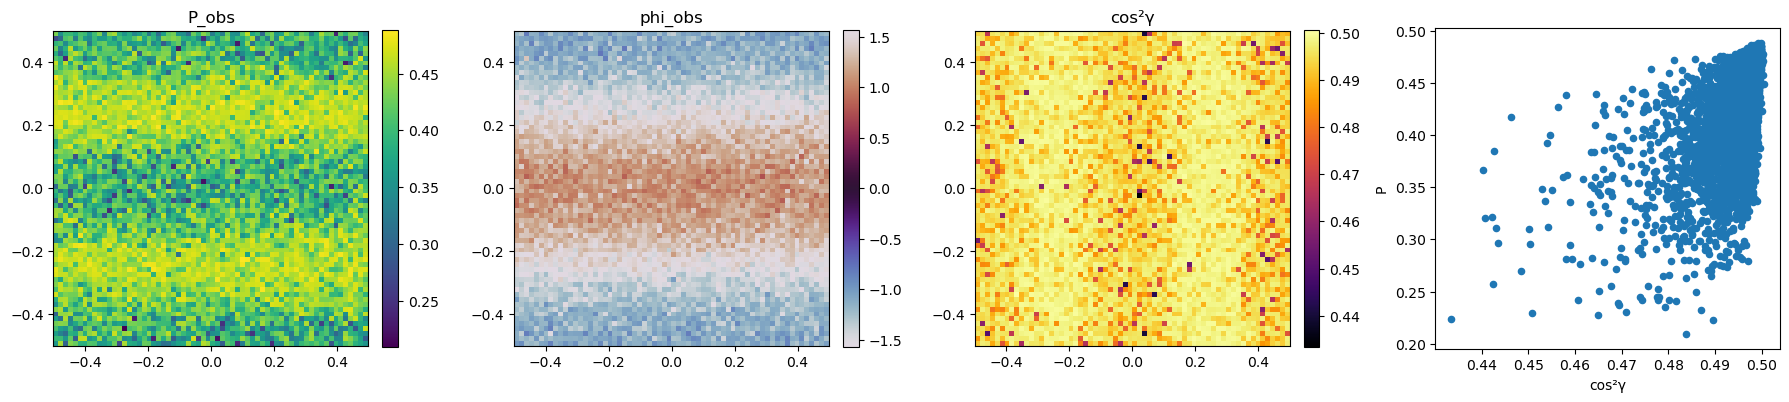

In [5]:
# plot
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
L=0.5
extent = [-L, L, -L, L]

im0 = axs[0].imshow(P.T, origin="lower", extent=extent, cmap="viridis")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title("P_obs")

im1 = axs[1].imshow(PHI.T, origin="lower", extent=extent, cmap="twilight")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("phi_obs")

im2 = axs[2].imshow(C, origin="lower",
                    extent=extent, cmap="inferno")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
axs[2].set_title("cos²γ")

axs[3].scatter(C.flatten(), P.flatten(), s=20, label='cos2g_LOS')
axs[3].set_xlabel("cos²γ")
axs[3].set_ylabel("P")
# axs[3].set_xlim(0.9,1.1)
plt.tight_layout()
plt.show()


### Check for depolarization in stokes U and Q map

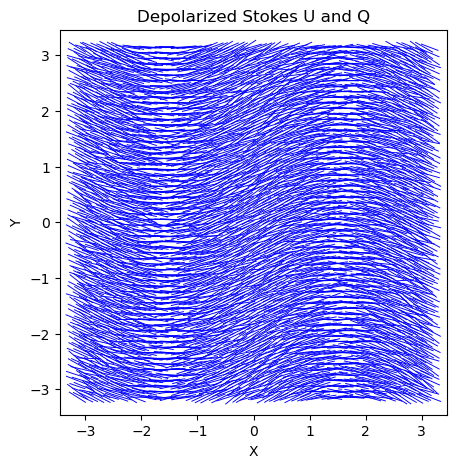

In [6]:
x = np.linspace(-np.pi, np.pi, gsize)
y = np.linspace(-np.pi, np.pi, gsize)
z = np.linspace(-np.pi, np.pi, gsize)
X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set_title('Depolarized Stokes U and Q')
x = np.sin(PHI)*P
y = np.cos(PHI)*P
ax.quiver(X[:,:,0], Y[:,:,0], x, y, scale=1, scale_units='xy',headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

### fractional polarization distributions for varying turbulence levels

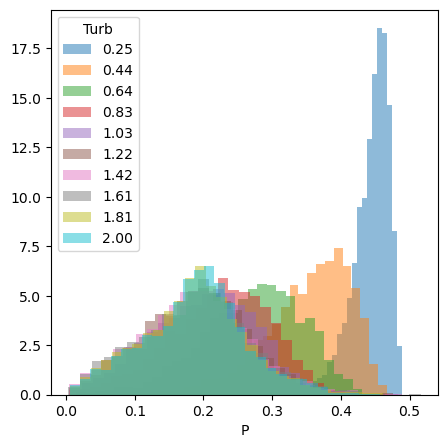

In [7]:
turb          = np.linspace(0.25,2,10)
bz_range      = np.linspace(0,1,4)
amp_end_range = np.linspace(0,1,10)


plt.figure(figsize=(5,5))

for iturb in turb:
    P, PHI, C = wavy_field_depol_test(turb_sigma = iturb, Bz_true = 1, amplitude_range = [1,1], 
                                      g_size = 64, plotting = False)
    plt.hist(P.flatten(), bins=30, alpha=0.5, label=f"{iturb:.2f}", density=True)
plt.xlabel("P")
plt.legend(title='Turb')

### Plot P, Phi, Zeeman, DCF maps

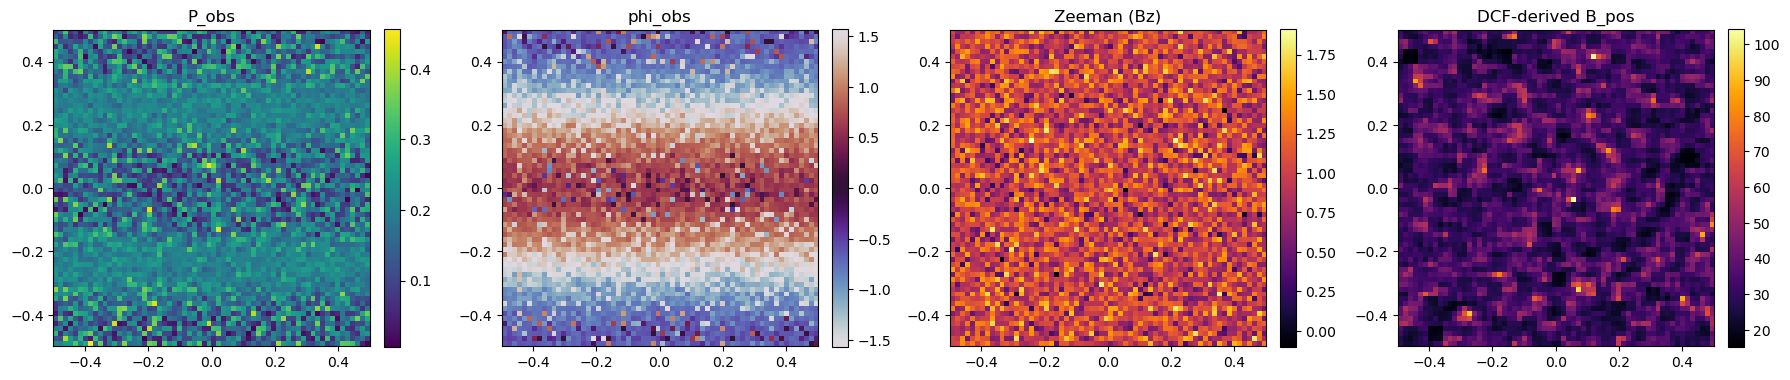

In [8]:
# === PLOTTING: a few diagnostic panels ===

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
L=0.5
extent = [-L, L, -L, L]

im0 = axs[0].imshow(P.T, origin="lower", extent=extent, cmap="viridis")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title("P_obs")

im1 = axs[1].imshow(PHI.T, origin="lower", extent=extent, cmap="twilight")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("phi_obs")

im2 = axs[2].imshow(zeeman_measured.T, origin="lower",
                    extent=extent, cmap="inferno")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
axs[2].set_title("Zeeman (Bz)")

im3 = axs[3].imshow(DCF_map.T, origin="lower",
                    extent=extent, cmap="inferno")
plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
axs[3].set_title("DCF-derived B_pos")


plt.tight_layout()
plt.show()


## Eventually can test Reconstruction on this model. This code will return Polarization, Zeeman, DCF observables which can then be used in the reconstruction method. 

In [ ]:
# # --- POS-projected magnetic field per voxel ---
# # Project B onto POS and apply geometric depolarization
# Bx_pos = Bx * C
# By_pos = By * C

# # Normalize for visualization only (orientation matters, not magnitude)
# norm = np.sqrt(Bx_pos**2 + By_pos**2)
# norm[norm == 0] = 1.0
# Bx_plot = Bx_pos /norm
# By_plot = By_pos / norm
# Bz_plot = np.zeros_like(Bx_plot)  # POS only

# # Subsample for clarity (optional)
# step = 1  # increase to thin vectors
# Xs = X[::step, ::step, ::step]
# Ys = Y[::step, ::step, ::step]
# Zs = Z[::step, ::step, ::step]

# fig = plt.figure(figsize=(9, 7))
# ax = fig.add_subplot(111, projection='3d')

# ax.quiver(
#     Xs, Ys, Zs,
#     Bx_plot[::step, ::step, ::step],
#     By_plot[::step, ::step, ::step],
#     Bz_plot[::step, ::step, ::step],
#     length=0.6,
#     arrow_length_ratio=0.0,   # <-- headless vectors
#     pivot='middle',
#     linewidth=1
# )

# ax.set_title("3D POS-projected magnetic field")
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")

# plt.tight_layout()
# plt.show()


In [ ]:

# plt.figure(figsize=(5,5))
# # scatter plot
# for iturb in turb:
#     P, PHI, C = wavy_field_depol_test(turb_sigma = 0.5, Bz_true = iturb, amplitude_range = [0,1], 
#                         g_size = 64, plotting = False)
#     plt.scatter(C.flatten(), P.flatten(), s=20, label=f"{iturb:.2f}")
#     # plt.scatter(np.ones(4096)+iturb, P.flatten(), s=20, label=f"{iturb:.2f}")
#     # plt.xlabel("arbitrary value, cos²γ == 1")
#     plt.xlabel("cos²γ")
#     plt.ylabel("P")
# plt.legend(title='Bz')
# plt.title("Varying Zeeman")